# Welcome to PyLongslit - the notebook version.

This is a more user friendly version of the [PyLongslit scripting software](
https://kostasvaleckas.github.io/PyLongslit/).


PyLongslit is simple Python software for reduction of astronomical long-slit spectra.
As for now, the software is tested and designed to work with data from 
[ALFOSC](https://www.not.iac.es/instruments/alfosc/) at the
Nordic Optical Telescope (NOT), but adaptions to other instruments should be 
possible - feel free to fork the repository and make your own changes.

The software was "born" as a series of executable scripts. The adaptation
of the software to be runnable in notebook cells is for now somewhat 
experimental and might be unstable. 

------------------------------

### Requirments
The scripts in the version differ from the scripts in the 
scripting version of the software - make sure you have the [correct 
files downloaded from the dedicated repository for the notebook version of the software.](https://github.com/KostasValeckas/PyLongslit_notebook
)


You need these files to run the software: 

```bash
├── calibrate.py
├── crremoval.py
├── PyLongslit_notebook.ipynb
├── extract_1d.py
├── identify.py
├── mkspecbias.py
├── mkspecflat.py
├── reduceobs.py
├── requirements.txt
├── sensfunction.py
├── standard.py
└── utils.py

```
This notebook produces a series of interactive windows, and you will therefore **need to run it on your local machine**. Any notebook-hosting services (such as binder, google colab etc.) will not work,
as they do not have the required back-end support for opening interactive windows.

------------------------------

### Example data

In the repository we also provide some example data and files that you can use
to get started with this notebook.

The notebook as it comes is set up to run with the example data, so if 
this is your first time running the notebook, you should be able to blindly 
run all cells without any alternations.

------------------------------


### Installing required python libraries

The below cell ensures that you have all neccesery python libraries installed. 
We recommend that you run this notebook from an [empty virtual environment.](https://kostasvaleckas.github.io/PyLongslit/installation.html#create-a-clean-python-environment)

You only have to run the below cell once, and it would be a good idea
to comment it out for succesive runs of the notebook.

In [ ]:
pip install -r requirements.txt

---------------------

### Importing the PyLongslit code and relevant libraries:

(make sure you don't move the downloaded scripts out of the directory,
as the notebook expects the scripts being in the same directory 
as the notebook)

In [ ]:
from mkspecbias import mkspecbias
from mkspecflat import mkspecflat

from crremoval import crremoval
from reduceobs import reduce_obs

from extract_1d import extract_1d_spec

from standard import standard

from sensfunction import sensfunc

from calibrate import calibrate

import os


--------------

### Setting input and output directories

In the below cell, you need to set the path to the directory with 
your raw data, and also to the directory where ourput should be stored.

If the output directory does not exist, it will be created automatically.

In [ ]:
### Directory with all raw data: 

INPUT_DIR = "./raw_example/"

### Directory where all output will be stored

OUTPUT_DIR = './output'

# If output directory does not exist, create it

if not os.path.exists(OUTPUT_DIR):

    os.makedirs(OUTPUT_DIR)

--------
### Set the x and y dimensions of your frames:

In [ ]:
xsize = 500
ysize = 2102

---------

# Pre-processing

In the following steps, some pre-processing of the raw data will be executed.
Pre-processing consists of subtraction of detector bias and flat-fielding of 
all observation frames (science, standard star and arc-lamp), as well as 
removal of cosmic rays from science and standard star observations.

The steps of the pre-processing are well known universal procedures in astronomical data reduction. We will therefore not explain the steps in detail, but encourage to search for their meaning online and in litterature, should they be not known to the user.

---------

### BIAS

Fill in the files names of your bias files in the input directory.

In [ ]:
bias_list = [
    "ALDh140351.fits",
    "ALDh140352.fits",
    "ALDh140353.fits",
    "ALDh140354.fits",
    "ALDh140355.fits",
    "ALDh140356.fits",
    "ALDh140357.fits",
    "ALDh140358.fits",
    "ALDh140359.fits",
    "ALDh140360.fits",
    "ALDh140361.fits"
    ]

Execute to produce a master bias frame:

In [ ]:
mkspecbias(xsize, ysize, bias_list, inp_dir=INPUT_DIR, out_dir=OUTPUT_DIR)

---------

### FLATS

Fill in the files names of your flat field files in the input directory.

In [ ]:
flat_list = [
    "ALDh130384.fits",
    "ALDh130385.fits",
    "ALDh130386.fits",
    "ALDh130387.fits",
    "ALDh130388.fits",
    "ALDh140211.fits",
    "ALDh140219.fits",
    "ALDh140230.fits",
    "ALDh140238.fits"
    ]

Execute to produce a master flat field frame:

In [ ]:
mkspecflat(xsize, ysize, flat_list, inp_dir=INPUT_DIR, out_dir=OUTPUT_DIR)

---------

### Cosmic - ray removal

In the following, removal of cosmic rays from the science and standard star
frames will be executed.

Firstly, set gain and read-out-noise detector parameters (can be found in the 
fits file headers):

In [ ]:
#Science

# THESE HAVE TO BE FOR YOUR OBSERVATION
gain = 0.16 # LOOK UP fitsfile[1].header['GAIN']
ron = 4.3 # LOOK UP fitsfile[1].header['RDNOISE']

Several paramters can also
be set for guiding the [astroscrappy.detect_cosmics method](https://astroscrappy.readthedocs.io/en/latest/api/astroscrappy.detect_cosmics.html),
but the default values should be sufficient in most cases:

In [ ]:
# THSE CAN BE SET DIFFERENTLY AS NEEDED
frac = 0.01
objlim = 15
sigclip = 5
niter = 5

Fill in the files names of your science observation
and standard star files in the input directory.

In [ ]:
list_science = [
    "ALDh120177.fits",
    "ALDh120178.fits"
]

list_standard = [
    "ALDh120217.fits"
]

Execute the following cell to remove cosmic rays from both science and 
standard star frames:

In [ ]:
crremoval(gain, 
          ron, 
          list_science,
          inp_dir=INPUT_DIR,
          out_dir=OUTPUT_DIR,
          frac=frac,
          objlim=objlim,
          sigclip=sigclip,
          niter=niter
          )

crremoval(gain, 
          ron, 
          list_standard,
          inp_dir=INPUT_DIR,
          out_dir=OUTPUT_DIR,
          frac=frac,
          objlim=objlim,
          sigclip=sigclip,
          niter=niter
          )

---

### Bias subtraction and flat-fielding of the science, standard star and arc lamp observations.

The following cell produces lists for the products of the last step 
(cosmic-ray removal). Simply execute it.

In [ ]:
# This helps to make lists with correct naming after 
# the cosmic rays have been removed: 

list_science_crr_removed = ["crr" + filename.split("/")[-1] for filename in list_science]
list_standard_crr_removed = ["crr" + filename.split("/")[-1] for filename in list_standard]

List the names of the arc lamp frames that are in your input directory:

In [ ]:
# Arc frames:

list_arc = [
    "ALDh120176.fits",
    "ALDh120179.fits"
]

In the following,the x-coordinate centers of the objects needs to be provided. If there are several
frames, make sure the centers are provided to match the frames in alphabetical order. 
In order to find the centers, open the observations with your preferred .fits image viewer, 
and read of the x-coordinates of the object centers manually.

This has to be done both for the science and standard star observations:

In [ ]:
centers_science = [250, 273] 

centers_standard = [251] 

The following cell runs the reductions:

In [ ]:
reduce_obs(xsize, 
           ysize, 
           centers_science, 
           list_science_crr_removed, 
           list_arc, 
           inp_dir=INPUT_DIR,
           out_dir=OUTPUT_DIR,   
           standard_star_reduction = False)



reduce_obs(xsize, 
           ysize, 
           centers_standard, 
           list_standard_crr_removed, 
           list_arc, 
           inp_dir=INPUT_DIR,
           out_dir=OUTPUT_DIR,   
           standard_star_reduction = True)

-----------

### Check the output

As this point, your output directory should contain a collection of products. 

The most important are: `arcsub.fits` and `arcsub_std.fits`
 (reduced arc-lamp frames), and the `obj.fits` and `std.fits` (the reduced 
science and standard star frames respectively). **These 4
are the files that will be used for further processing.** If you have aquired
the files `arcsub.fits`, `arcsub_std.fits`, `obj.fits` and `std.fits`, you can
continue. Don't move these files out of the output directory.



------------------

# Executing the pipeline 


----

## Manual identification of the arc-lamp lines.


In this step, we manually identify the lines in the arc-lamp spectrum, and fit
a polynomial function for describing wavelength as a function of pixel
(this function is called a **wavelength solution**). This later allows
us to calibrate the pixel values of the science and standard star frames
to wavelength values.
The identification is done in an interactive plotting window/GUI. 

**This step is by far the most time-consuming for the user, as 
a fair amount of user work is needed. Excpect this to be challenging
at first, if you have not tried this type of routine before.**

To run this script, you will also need a 
list with the arc lines for your specific setup. **You must set its' path in the cell below**.
For the example data, we provide the
list for the HeNe lamp used for the tutorial data. The path to it is already
set by default.

In [8]:
# Path to linelist
linelist = "./database_example/mylines_vac.dat"


As one will need a referrence spectrum with emission lines tagged with wavelentghs
to manually identify the lines (also called a **arc lamp map**), this also needs to be aquired. 
For the tutorial data, we provide such reference spectra for the
HeNe lamp used with the g04 grating for [ALFOSC](https://www.not.iac.es/instruments/alfosc/) in 4 PDF files in the 
`database_example` directory. 
These have been downloaded from the [ALFOSC website.](https://www.not.iac.es/instruments/alfosc/lamps/)

In the following, we provide a step-by-step guide on how to execute
the line identification:

1. **Run the script**: 
   The cell bellow will start a python program and open an interactive GUI.
   
   The window should look something like this:

   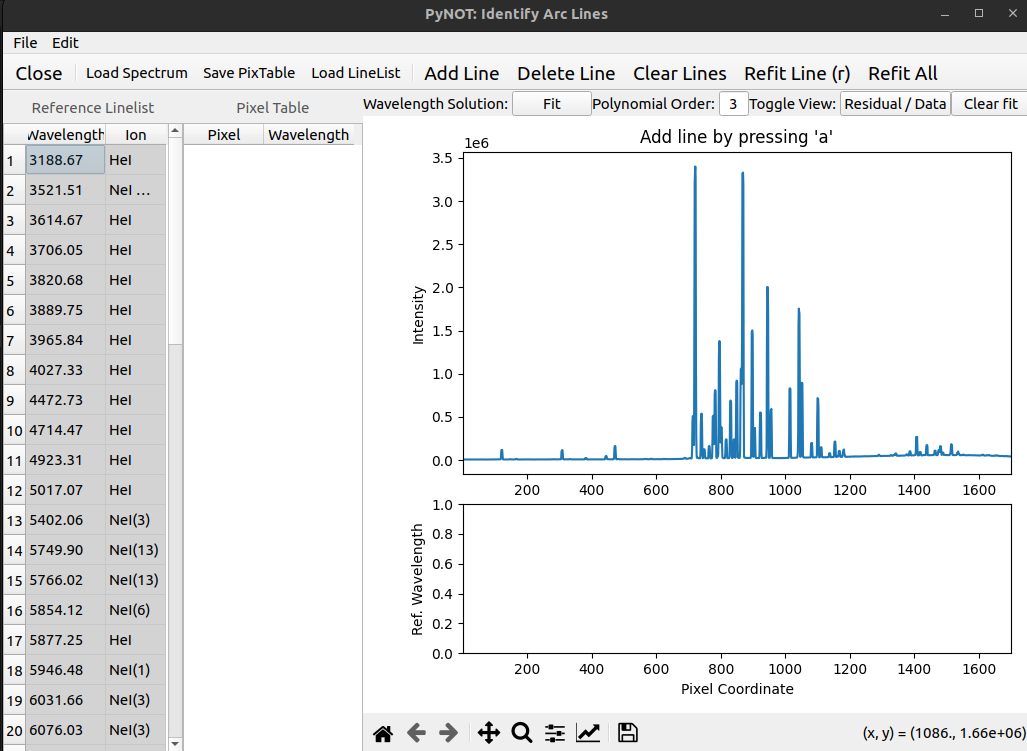

2. **Identifying the lines**: 
   In this step, you have to use the reference spectra provided in the `databse_example`
   directory (or downloaded elswhere for your own setup) to identify the
   wavelentghs of the lines in the arc spectrum. This is done by clicking on the
   `Add Line` button, and then clicking on the arc spectrum where you think a line
   is, and then manually typing in the wavelength of the line. Below is an 
   example for a small Helium portion of the spectrum, with a zoom in of the corresponding 
   reference spectrum:

   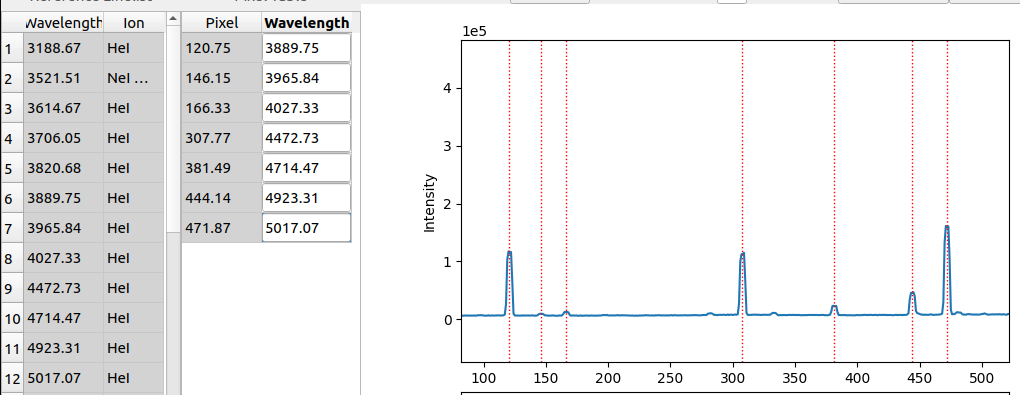

   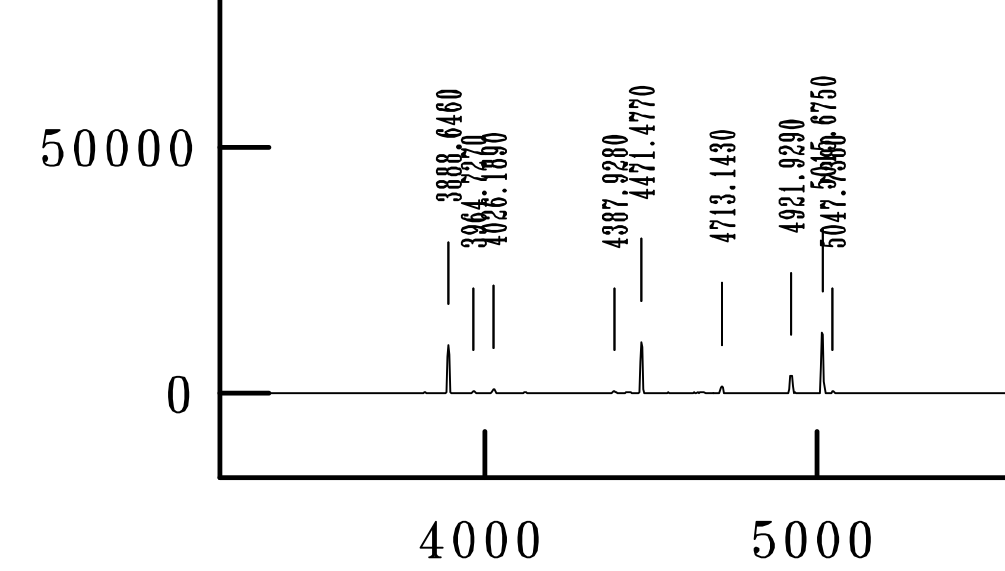

   (here there is a small offset in wavelentghs between the reference spectrum 
   (lowest picture) and the line list (upper left corner) - we have used the linelist,
   since the software will rely on the list later)

   After you have found a handfull of lines, you can click on the `Fit` button to
   make a polynomial fit for a function that describes wavelength as a function of
   pixel. You can use the `Residual/Data` button to change displays between the
   fit curve and the residuals of the fit in order to evaluate the fit quality. 
   For the small amount of lines shown above, this looks like this:

   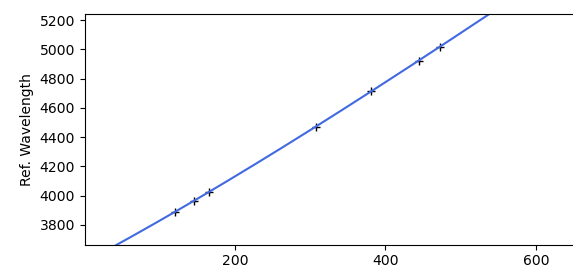

   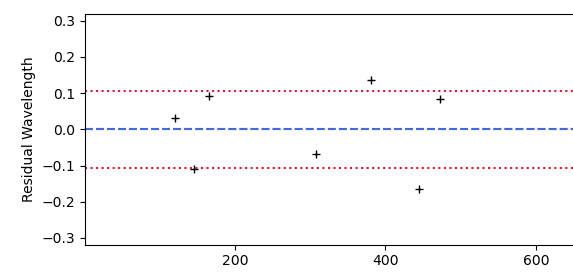

   When you have obtained a fit, and try to `Add Line` again, the program will
   use the fit to extrapolate the wavelength of the line you are trying to add,
   and look for it in the linelist. If it finds a match, it will automatically
   add it. If it does not find a match, it will show a message indicating so,
   but it will still add the line - you will then have to correct it manually.
   If your fit does not seem to be good, you can click on the `Clear fit` button
   to remove it, and then add more lines manually. You can also selectively remove
   one or all lines.

   From here on, you have to obtain the best possible fit by trial and error:

   1. Add lines manually
   2. Fit
   3. Use the fit to add more lines
   4. Refit - correct outlies - come back to 1. or 2. and repeat until you are satisfied with the fit.

   Remember that the calbrated 1d-spectrum will be flux as a function of wavelength - 
   therefore the quality of your fit will affect the quality of the final
   results significantly (as it will be used to determine wavelength, 
   and therefore the whole x-axis of your calibrated 1d-spectrum). 
   Even though this step is by far the most time-consuming, it 
   should not be rushed. However, you will very likely be unable to identify
   all lines, and the ones that causes uncertainty should be left out.
   This said, make sure you identify lines in all parts of the spectrum.

   5. **Saving the line list**: 
   When you are satisfied with the fit, you need to save the pixel table.
   Press `File` -> `Save PixTable` and save the file.

For the example data, we already pre-made a pixel table called `idarc.dat` in the `database_example` directory,
so you have a starting point to work with. You can inspect the file by pressing 
`File` -> `Load PixTable`. To proceed in the tutorial, 
you can either try to improve our fit, or move on directly using it. 


In [ ]:
os.system("python3 identify.py --lines " + linelist + " " + OUTPUT_DIR + "/arcsub.fits")

# On Windows, you might need to use python instead of python3:

# os.system("python identify.py --lines " + linelist + " " + OUTPUT_DIR + "/arcsub.fits")

-------

### Extraction of science and standard star 1d-spectra

The procedure for extracting the 1d spectrum of the science observation and the
standard star is the same, and therefore they will be described together. 

The following is an instruction/guide on any needed user input and evaluation
using the extraction.

1. **Evaluate wavelength calibration**

    Firstly, the script will do a refinement of the wavelength solution, 
    and produce some quality assurance plots. These look something like this:
    
    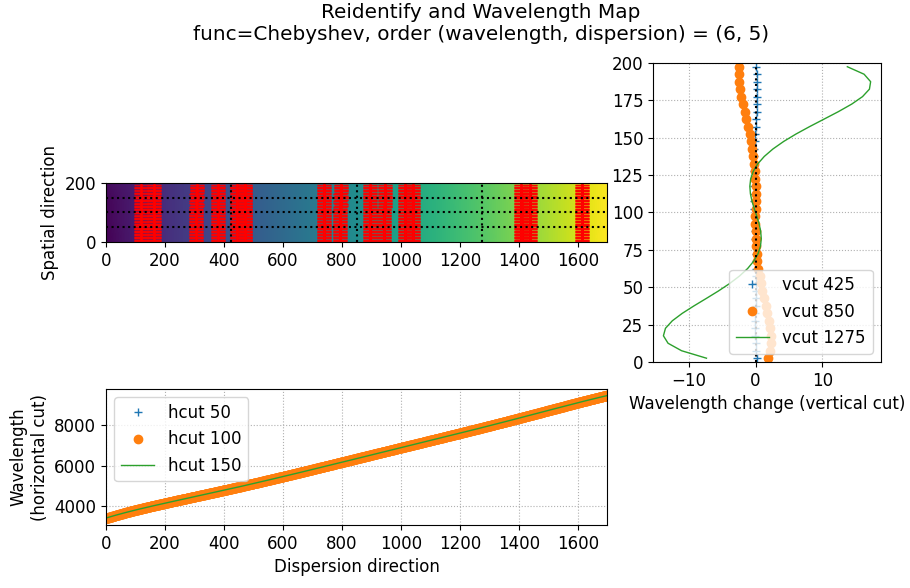

    The image on the top left is the detector image with a wavelength colormapped
    to every pixel. The red lines are the identified lines used in production
    of the wavelentgh solution. Here we are looking for a smooth and continuous
    colormap. The dashed black lines are the lines that are plotted in the
    curve plots (these are `the cuts`). `hcut` are the horizontal lines, and `vcut` are the vertical lines.
    For horizontal lines, we are looking for a smooth, somewhat constantly growing curve.
    For the vertical lines, some wavelength change is okay 
    in vertical direction, as it can be caused by optical effects. However, these
    should be smooth and continuous. We can assume that the object spectrum will 
    roughly be placed along one `hcut`, and it therefore has the most importance 
    to us. 

    If the results of the wavelength calibration are showing flaws,
    you need to find relevant parameters and adjust them in the cell below.

2. **Select the sky and object**

    In the next step, you will need to help the software to identify the sky and object.
    An interactive plot window will open, where you will have to use 5 mouse left-clicks 
    to identify (approximetly):

    1. The sky background on the left side of the object - start.
    2. The sky background on the left side of the object - end.
    3. The object center
    4. The sky background on the right side of the object - start.
    5. The sky background on the right side of the object - end.
    6. Press "q" when you are done.
   
    The plot prior and after clicking should look something like this:

    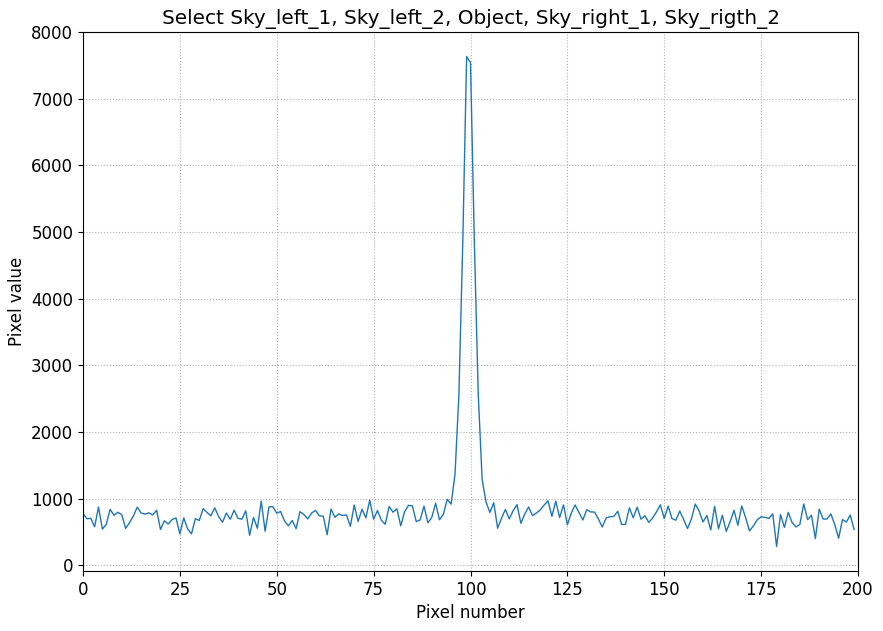

    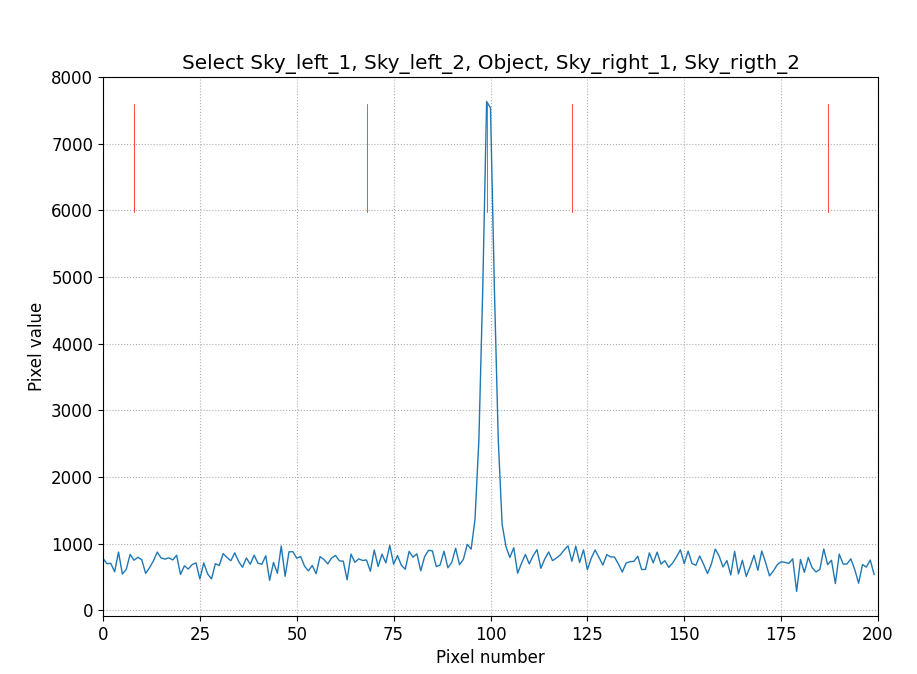

    The rest of the script is automatic.

    In the following we provide an array of quality assesment plots with
    comments of the expected results. If the results are not as expected,
    you need to find relevant parameters and adjust them in the cell below. 


3. **Evaluate results for the remainder of the extraction**

    The software will now perform a fit to the sky background,
    where we are looking for a line that goes through the sky background only:

    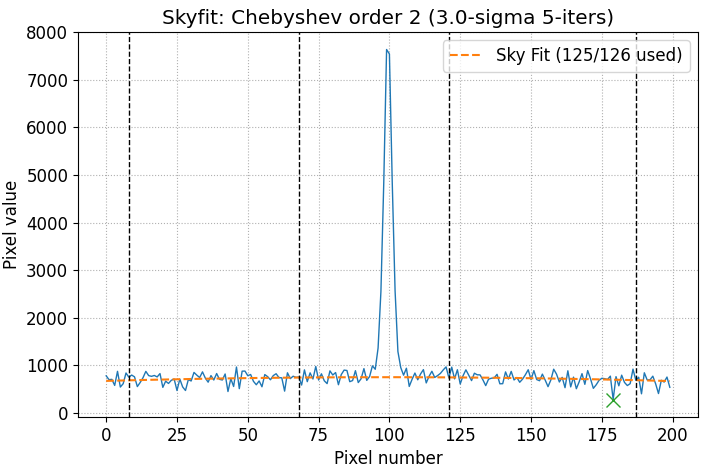  

    , and also a fit to the object trace, where we are looking for (somewhat)
    constant FWHM and a clean fit to object trace with a random residual spread:

    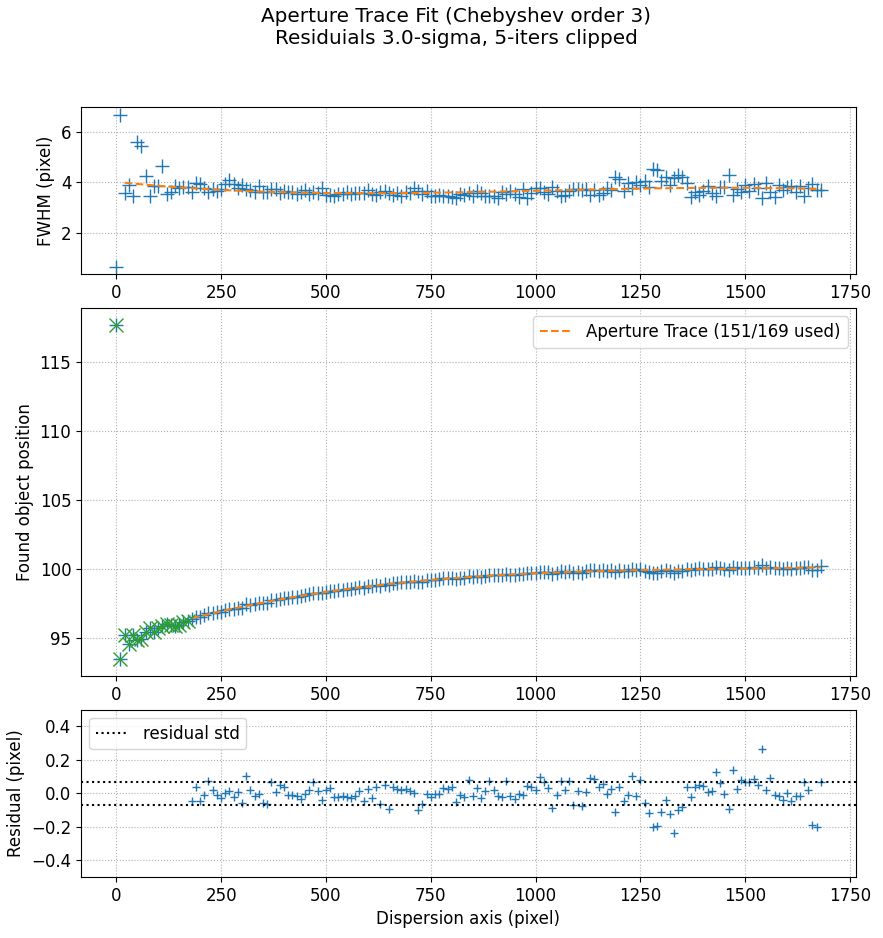

    The sky is then subtracted from the object, where we want to see the object
    trace with a uniform background after the subtraction:

    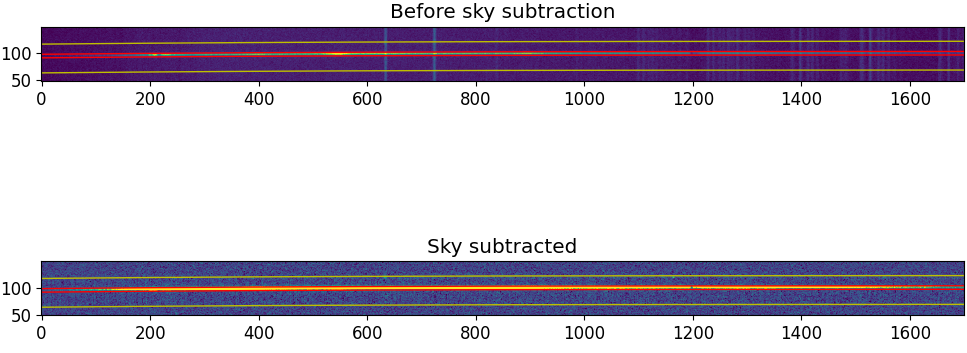

    Finally, the software will extract the 1d spectrum, and plot the result:

    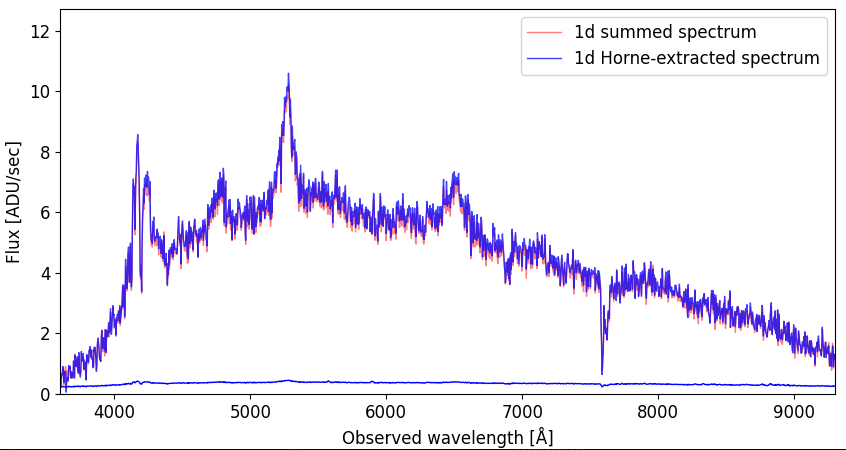


In the example data, the standard star object trace exhibits a wave-like pattern
in the residuals. This is an unwanted effect, and is caused by a finer
structure in the object trace. Some of this can be resolved by setting 
the `ORDER_APTRACE` parameter to a higher value,
and lowering the `SIGMA_APTRACE` parameter.
However, inspecting the curve plot itself, the fit seems to be 
sufficiently correct.



----------

These parameters can be changed to guide the extraction (these guide both 
standard star and science extractions - remember to change them back and forth
or copy the whole cell and rename them for easier distinction).

In [ ]:
# Parameters for IDENTIFY
FITTING_MODEL_ID = 'Chebyshev'
ORDER_ID = 6 
FWHM_ID = 2.5 # rough guess of FWHM of lines in IDENTIFY (pixels)

# Parameters for REIDENTIFY
FITTING_MODEL_REID = 'Chebyshev'
STEP_REID = 5  # Reidentification step size in pixels (spatial direction)
TOL_REID = 25 # tolerence to lose a line in pixels
ORDER_SPATIAL_REID = 5
ORDER_WAVELEN_REID = 6

# Parameters for APALL (sky fitting and aperture extract after sky subtraction)

## parameters for finding aperture
NSUM_AP = 10
FWHM_AP = 10
STEP_AP = 10  # Recentering step size in pixels (dispersion direction)

## parameters for aperture tracing
FITTING_MODEL_APTRACE = 'Chebyshev'
ORDER_APTRACE = 3
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 

## parameters for sky fitting
FITTING_MODEL_APSKY = 'Chebyshev'
ORDER_APSKY = 2
SIGMA_APSKY = 3
ITERS_APSKY = 5

DISPAXIS = 1  # 1 = line = python_axis_1 // 2 = column = python_axis_0

-----------
You need to set the path for the pixel table that was produced in the previous 
step (line identification):

In [ ]:
PIXEL_TABLE_PATH = "./database_example/idarc.dat"

-----------
Execute extraction of the science spectrum:

In [ ]:
# This re-wires some back-ends to make interactive windows appear
# outside the notebook.
%matplotlib qt

extract_1d_spec(
        standard_star = False,
        pixel_table_path=PIXEL_TABLE_PATH,
        out_dir = OUTPUT_DIR,
        FITTING_MODEL_ID = FITTING_MODEL_ID,
        FWHM_ID = FWHM_ID,
        ORDER_ID = ORDER_ID,
        FITTING_MODEL_REID = FITTING_MODEL_REID,
        TOL_REID = TOL_REID,
        STEP_REID = STEP_REID,
        ORDER_WAVELEN_REID = ORDER_WAVELEN_REID,
        ORDER_SPATIAL_REID = ORDER_SPATIAL_REID,
        NSUM_AP = NSUM_AP,
        STEP_AP = STEP_AP,
        FWHM_AP = FWHM_AP,
        FITTING_MODEL_APTRACE = FITTING_MODEL_APTRACE,
        ORDER_APTRACE = ORDER_APTRACE,
        SIGMA_APTRACE = SIGMA_APTRACE,
        ITERS_APTRACE = ITERS_APTRACE, 
        FITTING_MODEL_APSKY = FITTING_MODEL_APSKY,
        SIGMA_APSKY = SIGMA_APSKY,
        ITERS_APSKY = ITERS_APSKY,
        ORDER_APSKY = ORDER_APSKY,
        DISPAXIS = DISPAXIS)

-------------

Execute extraction of the standard star spectrum:

In [ ]:
# This re-wires some back-ends to make interactive windows appear
# outside the notebook.
%matplotlib qt

extract_1d_spec(
        standard_star = True,
        pixel_table_path=PIXEL_TABLE_PATH,
        out_dir = OUTPUT_DIR,
        FITTING_MODEL_ID = FITTING_MODEL_ID,
        FWHM_ID = FWHM_ID,
        ORDER_ID = ORDER_ID,
        FITTING_MODEL_REID = FITTING_MODEL_REID,
        TOL_REID = TOL_REID,
        STEP_REID = STEP_REID,
        ORDER_WAVELEN_REID = ORDER_WAVELEN_REID,
        ORDER_SPATIAL_REID = ORDER_SPATIAL_REID,
        NSUM_AP = NSUM_AP,
        STEP_AP = STEP_AP,
        FWHM_AP = FWHM_AP,
        FITTING_MODEL_APTRACE = FITTING_MODEL_APTRACE,
        ORDER_APTRACE = ORDER_APTRACE,
        SIGMA_APTRACE = SIGMA_APTRACE,
        ITERS_APTRACE = ITERS_APTRACE, 
        FITTING_MODEL_APSKY = FITTING_MODEL_APSKY,
        SIGMA_APSKY = SIGMA_APSKY,
        ITERS_APSKY = ITERS_APSKY,
        ORDER_APSKY = ORDER_APSKY,
        DISPAXIS = DISPAXIS)

-------------

### Preparing standard star spectrum for sensitivity function fitting:

In this and the following steps, the flux from the extracted 1d standard star spectrum (previous step), that at this point is still in ADU (analog to digital detector units), 
will be correlated with an archived spectrum from the same star that is given in 
wanted physical flux units. This allows to estimate detector sensitivity,
and later calibrate the science spectrum to physical flux units. 

In simpler and more loose terms - we want to go from detector counts to energy.

A reference spectrum is needed. We provide an example of such a file that fits the example data. It is called `mfeige110.dat` and is placed in the `database_example` directory. 
This file has been downloaded from the [ALFOSC homepage.](https://www.not.iac.es/instruments/alfosc/fluxstandard.html)

The path to the spectrum has to be set in the cell below:



In [ ]:
star_file_path = "./database_example/mfeige110.dat"

-------

In the next step, the user needs to manually mask what
parts of the extracted spectrum should be omitted from a later fit. Anything that would
interrupt later fitting process should be masked - this includes strong
emission/absorption lines, and other artifacts.

Running the cell below will open an interactive plot window, where you can mask the
spectrum parts by clicking on the plot. The masked parts will colored.
An example of the plot before and after masking is shown below:

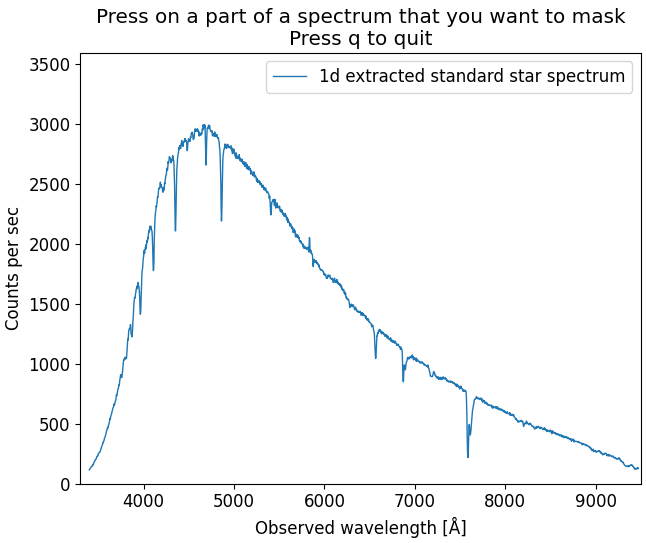

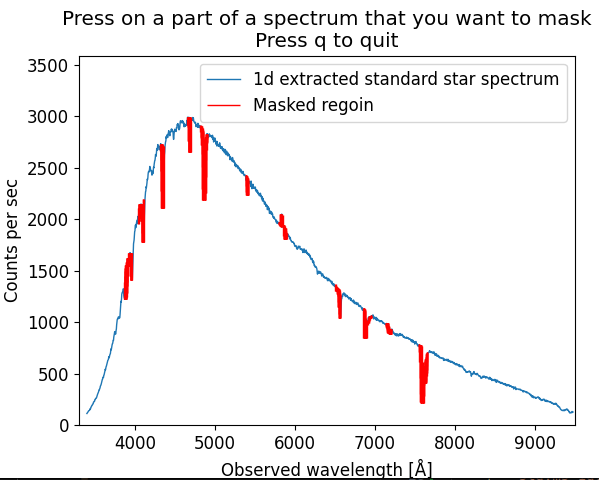

When the wanted parts are masked, press "q" and the script will 
do the rest automatically.

**IMPORTANT**: It is crucial that you consider the units of the reference spectrum 
file. As it comes, the `standard.py` script assumes the units of AB magnitude.
Change the definition of the `flam` parameter in the script itself if the unit conversion
is different (see the comments inside the script).


Run the cell below to execute the above described procedudre:

In [ ]:
# This re-wires some back-ends to make interactive windows appear
# outside the notebook.
%matplotlib qt


standard(star_file_path = star_file_path, out_dir = OUTPUT_DIR) 

--------------------

### Producing the sensitivty function.

This next procedure uses the calibrated standard star spectrum from the previous step
to fit a sensitivity function. The sensitivity function is a function
that describes the efficiency of the spectrograph as a function of
wavelength. The sensitivity function is used to convert the extracted
science spectrum from detector counts in ADU (analog to digital units)
to physical flux units.

A file describing the atmospheric extinction is needed in this procedure.
This file for the example data is named `lapalma.dat` (since the data is from 
the [NOT](https://www.not.iac.es/)), and is placed in the `databse_example`
directory. 

The path to the file needs to be set in the cell below:



In [ ]:
extinction_file_path = "./database_example/lapalma.dat"

The procedure is completely automatic. Execute the code below, and inspect the quality of the fit. The order of the polynomial can be changed directly with the `ORDER_SF` parameter, if the fit does not seem correct.

In [ ]:
sensfunc(out_dir = OUTPUT_DIR,
         extinction_file_path = extinction_file_path, 
         FITTING_MODEL_SF = 'Chebyshev', 
         ORDER_SF = 9)

### Calibrate to obtain the reudced and calibrate science spectrum

The last procedure applies the sensitivity function to perform final calibration 
of the extracted 1d science spectrum, and produces the final output (flux_obj.ms_1d.fits and flux_obj.ms_1d.dat).

In [ ]:
calibrate(out_dir = OUTPUT_DIR, extinction_file_path=extinction_file_path)